<a href="https://colab.research.google.com/github/akmuthun/stock_market_predictions_neural_net/blob/master/tesla_price_prediction_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error

import tensorflow as tf

import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np


In [61]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 9, 27)

df = web.DataReader("TSLA", 'yahoo', start, end)

data = df['Adj Close']
#read time series dataset assume only one column = "univariate"
dataset = data

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
# n_in = n_input = width of the sliding window which the number of input time steps in one row 
# of the training data. We can decide the value of "n_input"
# in the main code when we specify configurations.

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values


# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config, num_step):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input, n_out=num_step) 
	# separate inputs and outputs
	train_x, train_y = data[:, :-num_step], data[:, -num_step:] ##for train_y taking last three columns
	# define model
	model = tf.keras.Sequential([tf.keras.layers.Dense(n_nodes[0], activation='relu', input_dim=n_input),
	                             tf.keras.layers.Dense(n_nodes[1]),
															 tf.keras.layers.Dense(n_nodes[2]),
															 tf.keras.layers.Dense(n_nodes[3]),
															 tf.keras.layers.Dense(n_nodes[4]),
	                             tf.keras.layers.Dense(1)
															])
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# shape input for model
	x_input = array(history[-n_input:]).reshape((1, n_input))
	# make forecast
	yhat = model.predict(x_input, verbose=0)
	# correct forecast if it was differenced
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, num_step):
	error_collection=list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg, num_step)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)+1-num_step):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
    #find error in each forecast 
		err = measure_rmse(test[i:i+num_step], yhat)
    #add error to collection
		error_collection.append(err)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction mean error
	error = mean(error_collection)
	#print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, num_step, n_repeats=5):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config, num_step) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	return (result, config)

# grid search configs
def grid_search(data, cfg_list, n_test, num_step):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test, num_step) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort()
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [16,32]
	n_nodes = [[128,64,32,16,8]]
	n_epochs = [100, 1000, 1500]
	n_batch = [1024]
	n_diff = [0]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs


# number of time steps in the test dataset 
n_test = 6 # keep this fixed

data = dataset.values
step_list = []
cfg_list = []
error_list = []
window_length_list = []
nodes_list = []
epochs_list = []
batch_size_list = []
diff_list =[]

n_test = 230
for num in [num_step]:# number of steps to forecast, this can be any number between 1 and 5
	num_step = num 
	cfg_list = model_configs()
	scores = grid_search(data, cfg_list, n_test, num_step)
	print(scores)
	print('done for the step: %d' % num_step)
	error, cfg = scores[0]
	print(cfg, error)
	window_length_list.append(cfg[0])
	nodes_list.append(cfg[1])
	epochs_list.append(cfg[2])
	batch_size_list.append(cfg[3])
	diff_list.append(cfg[4])
	error_list.append(error)
	step_list.append(num_step)

collection = DataFrame()
collection['Predict Step'] = step_list
collection['Error'] = error_list
collection['window width'] = window_length_list
collection['Nodes'] = nodes_list
collection['Epochs'] = epochs_list
collection['batch size'] = batch_size_list
collection['difference'] = diff_list
collection.to_csv('TS.csv')

Total configs: 6
[(6.483656510062839, [16, [128, 64, 32, 16, 8], 1000, 1024, 0]), (6.599336879564367, [16, [128, 64, 32, 16, 8], 1500, 1024, 0]), (7.1419605951723835, [32, [128, 64, 32, 16, 8], 1500, 1024, 0]), (7.342157022227411, [32, [128, 64, 32, 16, 8], 1000, 1024, 0]), (9.601598470936652, [16, [128, 64, 32, 16, 8], 100, 1024, 0]), (11.252345063582709, [32, [128, 64, 32, 16, 8], 100, 1024, 0])]
done for the step: 1
[16, [128, 64, 32, 16, 8], 1000, 1024, 0] 6.483656510062839


In [0]:
n_input = 16
n_nodes = [128, 64, 32, 16, 8]
n_epochs = 1000
n_batch = 1024
num_step = 1
n_test = 230

n_in = n_input
n_out = num_step

data = df['Adj Close'].values

prepared_data = series_to_supervised(data, n_in, n_out)
train_x, train_y = prepared_data[:, :-num_step], prepared_data[:, -num_step:]
X_train, X_test = train_x[:-n_test,:], train_x[-n_test:,:]
y_train, y_test = train_y[:-n_test], train_y[-n_test:]

model = tf.keras.Sequential([tf.keras.layers.Dense(n_nodes[0], activation='relu', input_dim=n_input),
	                             tf.keras.layers.Dense(n_nodes[1]),
															 tf.keras.layers.Dense(n_nodes[2]),
															 tf.keras.layers.Dense(n_nodes[3]),
															 tf.keras.layers.Dense(n_nodes[4]),
	                             tf.keras.layers.Dense(1)
															])
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, verbose=0)
predictions = model.predict(X_test)


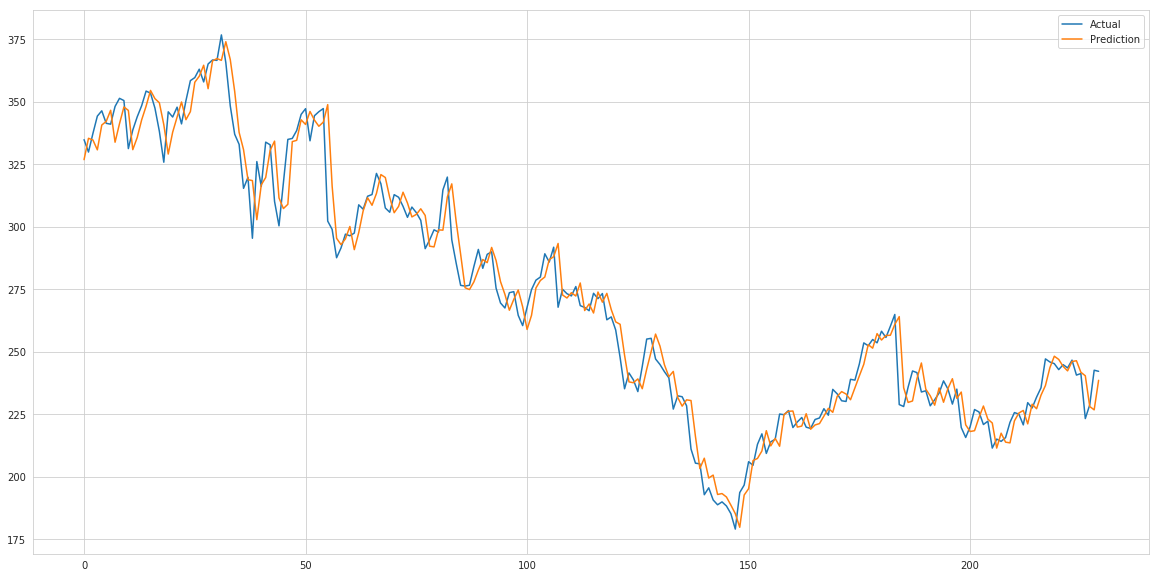

In [63]:
fig = plt.figure(figsize=(20, 10))
plt.plot(y_test)
plt.plot(predictions)
plt.legend(['Actual','Prediction'])
plt.show()